In [ ]:
LATENT_FEATURES = 256
VOXEL_RESOLUTION = 64  

In [2]:
import trimesh
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

In [ ]:
def stl_to_voxel(stl_path, resolution=VOXEL_RESOLUTION, target_shape=(VOXEL_RESOLUTION, VOXEL_RESOLUTION, VOXEL_RESOLUTION)):

    mesh = trimesh.load(stl_path)


    voxels = mesh.voxelized(pitch=mesh.extents.max() / resolution).matrix


    voxels_tensor = torch.tensor(voxels, dtype=torch.float32).unsqueeze(0)

    voxels_resized = torch.nn.functional.interpolate(
        voxels_tensor.unsqueeze(0), size=target_shape, mode='trilinear', align_corners=False
    ).squeeze(0)

    return voxels_resized

In [ ]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

class STLDataset(Dataset):
    def __init__(self, img_dir, stl_dir, resolution=64):

        self.img_dir = img_dir
        self.stl_dir = stl_dir
        self.resolution = resolution
        
    
        self.stl_files = [f for f in os.listdir(stl_dir) if f.endswith('.stl')]
        self.img_files = []

        for stl_file in self.stl_files:
            base_name = os.path.splitext(stl_file)[0]

            img_paths = []
            for view in ['f', 'r', 't']:  
                img_file = f"{base_name}_{view}.png"
                img_path = os.path.join(img_dir, img_file)
                if os.path.exists(img_path):
                    img_paths.append(img_path)
            

            if len(img_paths) == 3:
                self.img_files.append((img_paths, stl_file))
        

        self.transform = transforms.Compose([
            transforms.Resize((self.resolution, self.resolution)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_paths, stl_file = self.img_files[idx]

        imgs = []
        for img_path in img_paths:  
            img = Image.open(img_path).convert('RGB')
            img = self.transform(img)
            imgs.append(img)


        imgs = torch.stack(imgs) 
        

        stl_path = os.path.join(self.stl_dir, stl_file)
        voxel = stl_to_voxel(stl_path, self.resolution)  

        return imgs, voxel

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.threshold = nn.Parameter(torch.tensor(0.5))
        
        self.encoder = nn.Sequential(
            nn.Conv3d(3, 32, kernel_size=3, stride=2, padding=1),  
            nn.ReLU(),
            nn.Conv3d(32, 64, kernel_size=3, stride=2, padding=1),  
            nn.ReLU(),
            nn.Conv3d(64, 128, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
        )

        self.fc1 = nn.Linear(128 * 1 * 16 * 16, 1024)
        self.fc2 = nn.Linear(1024, 128 * 8 * 8 * 8)  

        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  
            nn.ReLU(),
            nn.ConvTranspose3d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),   
            nn.ReLU(),
            nn.ConvTranspose3d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),   
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1) 
        x = self.fc1(x)
        x = self.fc2(x)
        x = x.view(x.size(0), 128, 8, 8, 8)
        x = self.decoder(x)
        binary_preds = torch.sigmoid(x - self.threshold)
        return binary_preds

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class SSZGeneratorAdapted(nn.Module):
    def __init__(self):
        super(SSZGeneratorAdapted, self).__init__()
        
        # Порог для бинаризации
        self.threshold = nn.Parameter(torch.tensor(0.5))

        # 2D Encoder блоки
        self.encoder_block1 = self._create_2d_block(3, 32)   # 512x512x3 -> 256x256x32
        self.encoder_block2 = self._create_2d_block(32, 64)  # 256x256x32 -> 128x128x64
        self.encoder_block3 = self._create_2d_block(64, 128) # 128x128x64 -> 64x64x128
        self.encoder_block4 = self._create_2d_block(128, 256) # 64x64x128 -> 1x1x256

        # Fully connected layers для преобразования в 3D
        self.fc1 = nn.Linear(256 * 1 * 1, 1024)
        self.fc2 = nn.Linear(1024, 128 * 8 * 8 * 8)  # Преобразуем в 3D

        # 3D Decoder блоки
        self.decoder_block1 = self._create_3d_block(128, 64) # 8x8x8 -> 16x16x16
        self.decoder_block2 = self._create_3d_block(64, 32)  # 16x16x16 -> 32x32x32
        self.decoder_block3 = self._create_3d_block(32, 1, final_activation='sigmoid') # 32x32x32 -> 64x64x64

    def _create_2d_block(self, in_channels, out_channels):
        """
        Создает блок с 2D сверточными слоями.
        """
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=1), # Point Conv
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2)  # Уменьшаем размер изображения
        )

    def _create_3d_block(self, in_channels, out_channels, final_activation=None):
        """
        Создает блок с 3D транспонированной сверточной сетью.
        """
        layers = [
            nn.ConvTranspose3d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels)
        ]
        if final_activation == 'sigmoid':
            layers.append(nn.Sigmoid())
        return nn.Sequential(*layers)

    def forward(self, x):
        # 2D Encoder
        x = self.encoder_block1(x)
        x = self.encoder_block2(x)
        x = self.encoder_block3(x)
        x = self.encoder_block4(x)

        # Flatten и переход к Fully Connected
        x = x.view(x.size(0), -1)  # Преобразуем в вектор
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(x.size(0), 128, 8, 8, 8)  # Преобразуем обратно в 3D

        # 3D Decoder
        x = self.decoder_block1(x)
        x = self.decoder_block2(x)
        x = self.decoder_block3(x)

        # Применяем порог для бинаризации
        binary_preds = (x > self.threshold).float()

        return binary_preds


In [6]:
class WeightedLoss(nn.Module):
    def __init__(self, alpha=2.0):
        super(WeightedLoss, self).__init__()
        self.alpha = alpha

    def forward(self, predictions, targets, threshold):
        probs = predictions

        false_positive = probs * (1 - targets)  
        false_negative = (1 - probs) * targets  

        fp_loss = false_positive.sum() * self.alpha
        fn_loss = false_negative.sum()

        total_loss = (fp_loss + fn_loss) / targets.numel()
        return total_loss

In [3]:
def train_autoencoder(img_dir, stl_dir, epochs=2, batch_size=4, lr=0.0005, val_split=0.2, resolution=128):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    dataset = STLDataset(img_dir, stl_dir, resolution=resolution)
    train_size = int((1 - val_split) * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = SSZGeneratorAdapted().to(device)
    model.load_state_dict(torch.load('autoencoder_weights.pth', map_location=device, weights_only=True)) 
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCELoss()


    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for imgs, targets in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
            imgs, targets = imgs.to(device), targets.to(device)

            optimizer.zero_grad()
            output = model(imgs)

            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        weights_save_path = f"autoencoder_weights_1{epoch}.pth"


        torch.save(model.state_dict(), weights_save_path)
        print(f"Weights saved at {weights_save_path}")

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for imgs, targets in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{epochs}"):
                imgs, targets = imgs.to(device), targets.to(device)

                output = model(imgs)

                loss = loss_fn(output, targets)
                val_loss += loss.item()

        train_loss_avg = train_loss / len(train_loader)
        val_loss_avg = val_loss / len(val_loader)
        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss_avg:.4f}, Val Loss: {val_loss_avg:.4f}")

    return model

In [4]:
import torch
import gc

def clear_cache():

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    gc.collect()

In [5]:
clear_cache()

In [6]:
img_dir = 'CSG_data_PNG'
stl_dir = '../STL_Data'
model = train_autoencoder(img_dir, stl_dir)

Using device: cuda


NameError: name 'STLDataset' is not defined

In [ ]:
weights_save_path = "autoencoder_weights.pth"

torch.save(model.state_dict(), weights_save_path)
print(f"Weights saved at {weights_save_path}")


Weights saved at autoencoder_weights.pth


In [135]:
MODEL_NAME = '00011278'

In [ ]:
import torch
from PIL import Image
from torchvision import transforms
import numpy as np

def load_model(weights_path, device='cpu', resolution=128):

    model = AutoEncoder()
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.to(device)
    model.eval()
    return model

def preprocess_images(img_paths, resolution=128):

    transform = transforms.Compose([
        transforms.Resize((resolution, resolution)),
        transforms.ToTensor(),
    ])
    
    imgs = []
    for img_path in img_paths:
        img = Image.open(img_path).convert('RGB')
        img = transform(img)
        imgs.append(img)
    
    imgs_tensor = torch.stack(imgs)
    
    imgs_tensor = imgs_tensor.unsqueeze(0)
    return imgs_tensor

def infer_3d_model(model, img_paths, resolution=128, device='cpu'):

    imgs_tensor = preprocess_images(img_paths, resolution=resolution)
    imgs_tensor = imgs_tensor.to(device)

    with torch.no_grad():
        output = model(imgs_tensor)
    return output.squeeze(0) 



img_paths = [f"CSG_data_PNG/{MODEL_NAME}_f.png", f"CSG_data_PNG/{MODEL_NAME}_r.png", f"CSG_data_PNG/{MODEL_NAME}_t.png"]
    

weights_path = "autoencoder_weights_10.pth"
    

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    

model = load_model(weights_path, device=device)

output_3d_model = infer_3d_model(model, img_paths, resolution=128, device=device)
    
print(f"Размер 3D модели: {output_3d_model.shape}")

C:\Users\Maksim\AppData\Local\Temp\ipykernel_17252\322997044.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location

Размер 3D модели: torch.Size([1, 64, 64, 64])


In [126]:
output_3d_model = output_3d_model.squeeze()

In [127]:
output_3d_model.shape

torch.Size([64, 64, 64])

In [128]:
binary_tensor = (output_3d_model > output_3d_model.mean()).float()

In [129]:
binary_tensor.shape

torch.Size([64, 64, 64])

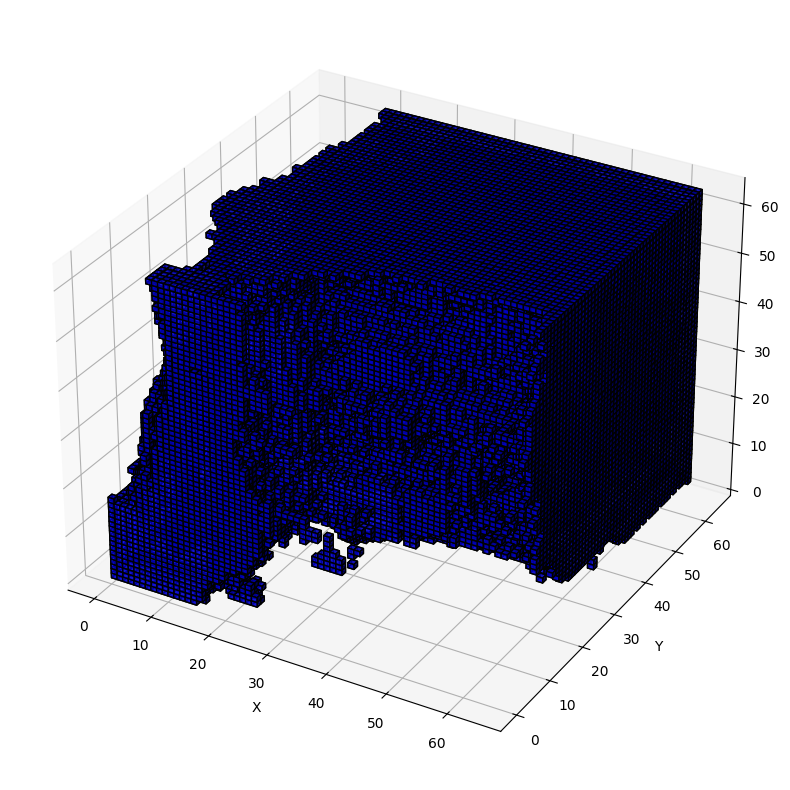

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_voxel_model(voxel_tensor):

    if isinstance(voxel_tensor, torch.Tensor):
        voxel_tensor = voxel_tensor.cpu().numpy()
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    ax.voxels(voxel_tensor, facecolors='blue', edgecolors='k', alpha=0.7)
    
    # Настраиваем оси
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    plt.show()

plot_voxel_model(binary_tensor)

In [ ]:
import torch
import trimesh

def stl_to_voxel(stl_path, resolution=VOXEL_RESOLUTION, target_shape=(64, 64, 64)):

    mesh = trimesh.load(stl_path)

    voxels = mesh.voxelized(pitch=mesh.extents.max() / resolution).matrix

    voxels_tensor = torch.tensor(voxels, dtype=torch.float32).unsqueeze(0)


    voxels_resized = torch.nn.functional.interpolate(
        voxels_tensor.unsqueeze(0), size=target_shape, mode='trilinear', align_corners=False
    ).squeeze(0)

    return voxels_resized

In [ ]:
stl_path = f"../STL_Data/{MODEL_NAME}.stl" 
resolution = 64  
    

voxel_tensor = stl_to_voxel(stl_path, resolution)
voxel_tensor = voxel_tensor.squeeze()

ValueError: string is not a file: ../STL_Data/00000037.stl

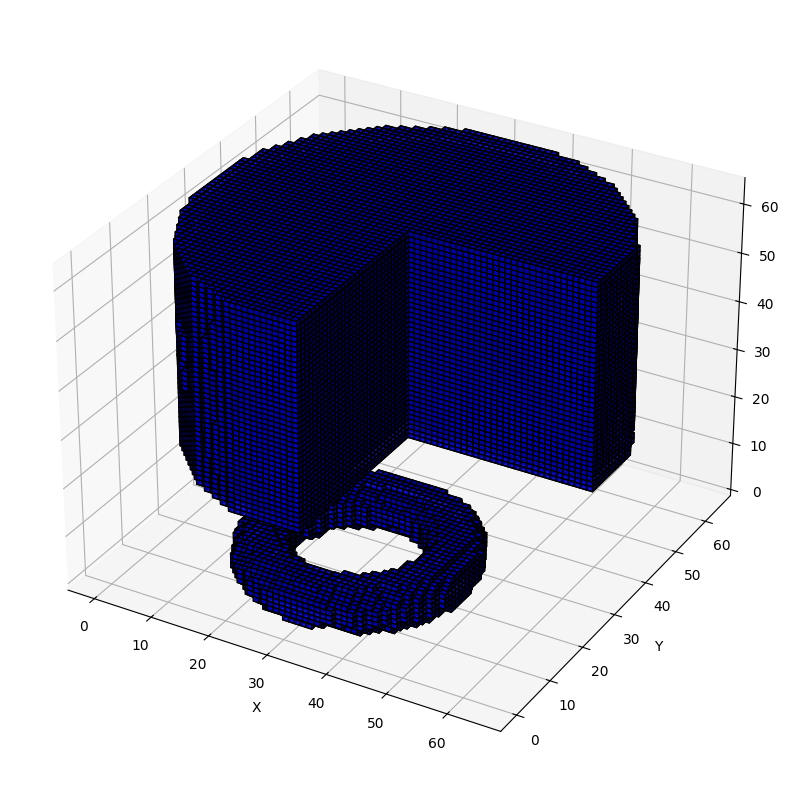

In [ ]:
plot_voxel_model(voxel_tensor)

In [ ]:
stl_path = f"ModelsSTL\{MODEL_NAME}.stl"  # Путь к STL-файлу
resolution = 64  # Размер воксельной сетки
    
# Преобразуем STL в воксели
voxel_tensor = stl_to_voxel(stl_path, resolution)
voxel_tensor = voxel_tensor.squeeze()
plot_voxel_model(voxel_tensor)

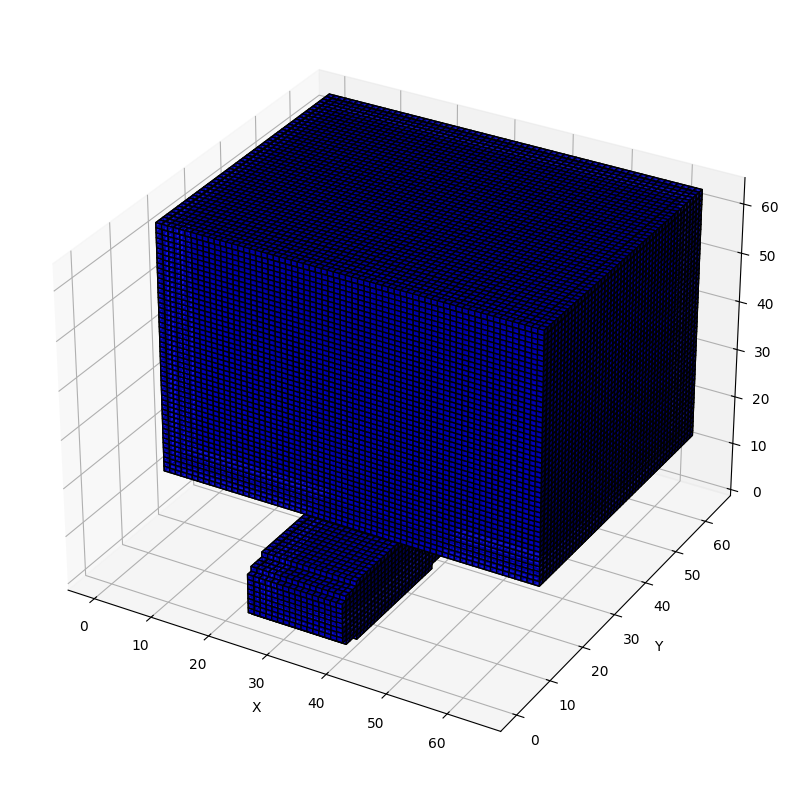

In [134]:
plot_voxel_model(voxel_tensor)

In [ ]:
# 

# Intersection Idea

In [ ]:
MODEL_NAME = '00011254'

In [ ]:

img_paths = [f"../test_drafts/PNG/{MODEL_NAME}_f.png", f"../test_drafts/PNG/{MODEL_NAME}_r.png", f"../test_drafts/PNG/{MODEL_NAME}_t.png"]
    
weights_path = "autoencoder_weights_10.pth"
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = load_model(weights_path, device=device)

output_3d_model = infer_3d_model(model, img_paths, resolution=128, device=device)

print(f"Размер 3D модели: {output_3d_model.shape}")

C:\Users\Maksim\AppData\Local\Temp\ipykernel_17252\322997044.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location

Размер 3D модели: torch.Size([1, 64, 64, 64])


In [255]:
MODEL_NAME

'00011254'

In [ ]:
output_3d_model = output_3d_model.squeeze()
binary_tensor = (output_3d_model > output_3d_model.mean()/3).float()


In [ ]:
stl_path = f"Test_Models_STL\{MODEL_NAME}.stl" 
resolution = 64 
    

voxel_tensor = stl_to_voxel(stl_path, resolution)
voxel_tensor = voxel_tensor.squeeze()


In [258]:
MODEL_NAME

'00011254'

In [ ]:

binary_tensor = binary_tensor.to('cpu')

voxel_tensor = voxel_tensor.to('cpu')
binary_tensor_bool = (binary_tensor).bool()
voxel_tensor_bool = voxel_tensor.bool()


intersection = binary_tensor_bool & voxel_tensor_bool
union = binary_tensor_bool + voxel_tensor_bool


In [260]:
#plot_voxel_model(voxel_tensor_bool)

In [261]:
#plot_voxel_model(intersection)

In [262]:
#plot_voxel_model(union)

In [263]:
import numpy as np
import trimesh
from skimage import measure

def voxel_to_stl(voxel_tensor, stl_path):

    if isinstance(voxel_tensor, torch.Tensor):
        voxel_tensor = voxel_tensor.cpu().numpy()
    
    vertices, faces, _, _ = measure.marching_cubes(voxel_tensor, level=0.5)
    
    mesh = trimesh.Trimesh(vertices=vertices, faces=faces)

    mesh.export(stl_path)
    print(f"STL-файл сохранен по пути: {stl_path}")
 
stl_path = "test_fin.stl"
voxel_to_stl(intersection, stl_path)

STL-файл сохранен по пути: test_fin.stl


In [264]:
stl_path = "intresect.stl"
voxel_to_stl(intersection, stl_path)

STL-файл сохранен по пути: intresect.stl


In [265]:
stl_path = "union.stl"
voxel_to_stl(union, stl_path)

STL-файл сохранен по пути: union.stl


In [ ]:

binary_tensor = binary_tensor.to('cpu')

voxel_tensor = voxel_tensor.to('cpu')
binary_tensor_bool = (binary_tensor).int()
voxel_tensor_bool = voxel_tensor.int()


intersection = binary_tensor_bool & voxel_tensor_bool
union = binary_tensor_bool | voxel_tensor_bool
#plot_voxel_model(intersection)

In [267]:
stl_path = "algo_m.stl"
voxel_to_stl(voxel_tensor, stl_path)

STL-файл сохранен по пути: algo_m.stl


In [268]:
stl_path = "model_m.stl"
voxel_to_stl(binary_tensor, stl_path)

STL-файл сохранен по пути: model_m.stl
